In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
with open('pickles/wiktionary_buckets_merge_almost_rhymes.pickle','rb') as f:
    wikibuckets = pickle.load(f)

In [3]:
with open("pickles/good_buckets.pickle", "rb") as f:
    good_buckets = pickle.load(f)
    
with open("pickles/manual_repair_buckets.pickle", "rb") as f:
    man_buckets = pickle.load(f)

norsc_buckets = good_buckets + man_buckets

# Vocab overlap between wiktionary and annotations

In [4]:
with open("tsvs/wiktionary_pairs_vocab.tsv") as f:
    s1 = f.read()
    
with open("tsvs/annotation_pairs_vocab.tsv") as f:
    s2 = f.read()

wikipedia_vocab = set(s1.split("\t"))
    
annotations_vocab = set(s2.split("\t"))

vocab_sizes_added = len(wikipedia_vocab)+len(annotations_vocab)
overlap = wikipedia_vocab.intersection(annotations_vocab)

print(f"len(wikipedia_vocab) {len(wikipedia_vocab)}\nlen(annotations_vocab) {len(annotations_vocab)}")
print(f"Vocab sizes added: {vocab_sizes_added}")
print(f"Vocab overlap: {len(overlap)}")


# vocab.update(vocab_)
# print(f"Vocab overlap: {vocab_sizes_added-len(vocab)}")
# "Number of unique words in combined vocab:", len(vocab)

len(wikipedia_vocab) 1384
len(annotations_vocab) 6290
Vocab sizes added: 7674
Vocab overlap: 114


## Merge NoRSC-buckets into wiktionary-buckets

In [5]:
len(wikibuckets), len(norsc_buckets)

(27, 596)

In [6]:
w_b = {}
for w in overlap:
    for i, b in enumerate(wikibuckets):
        if w in b:
            w_b[w] = [i]
    for i, b in enumerate(norsc_buckets):
        if w in b:
            w_b[w].append(i)

# if len=1 then the word is not in a norsc-bucket
w_b = {w:b for w,b in w_b.items() if len(b) == 2}

w_b

{'skjønn': [5, 26],
 'bli': [8, 578],
 'le': [6, 571],
 'gården': [12, 512],
 'tid': [8, 576],
 'tørn': [16, 217],
 'sympati': [8, 578],
 'gi': [8, 578],
 'vil': [4, 3],
 'fred': [6, 571],
 'til': [4, 3],
 'hul': [22, 154],
 'stønn': [5, 26],
 'harmoni': [8, 578],
 'ski': [8, 578],
 'meg': [6, 543],
 'si': [8, 578],
 'raseri': [8, 578],
 'kort': [18, 593],
 'kne': [6, 571],
 'blid': [8, 576],
 'nid': [8, 576],
 'bil': [4, 3],
 'be': [6, 571],
 'med': [6, 571],
 'deg': [6, 543],
 'tyranni': [8, 578],
 'sort': [18, 592],
 'ned': [6, 571],
 'hi': [8, 578],
 'smil': [4, 3],
 'mil': [4, 3],
 'port': [2, 592],
 'tort': [2, 593],
 'perleport': [2, 592],
 'lønn': [5, 26],
 'parti': [8, 578],
 'spill': [4, 3],
 'det': [6, 571],
 'gli': [8, 578],
 'se': [6, 571],
 'energi': [8, 578],
 'ul': [22, 154],
 've': [6, 571],
 'hvil': [4, 3],
 'il': [4, 3],
 'fil': [4, 3],
 'kjært': [1, 225],
 'snert': [1, 494],
 'seg': [6, 543],
 'april': [4, 3],
 'befri': [8, 578],
 'dertil': [4, 3],
 'skje': [6, 571]

In [7]:
o_b1, o_b2 = zip(*w_b.values())
s_ob1 = set(o_b1)
s_ob2 = set(o_b2)
len(s_ob1), len(s_ob2)

(11, 15)

In [8]:
s_ob1, s_ob2

({1, 2, 4, 5, 6, 8, 12, 14, 16, 18, 22},
 {3, 26, 154, 217, 225, 291, 465, 494, 512, 543, 571, 576, 578, 592, 593})

In [9]:
not_overlap_wikibuckets = [i for i,b in enumerate(wikibuckets) if i not in o_b1]
not_overlap_norsc_buckets = [i for i,b in enumerate(norsc_buckets) if i not in o_b2]
len(not_overlap_wikibuckets) + len(not_overlap_norsc_buckets)

597

In [10]:
merges = {}

for i1, i2 in w_b.values():
    i1 = str(i1)
    put = False
    if i1 in merges:
        merges[i1].add(i2)
    else:
        merges[i1] = {i2}
merges

{'5': {26},
 '8': {576, 578},
 '6': {543, 571},
 '12': {512},
 '16': {217, 291},
 '4': {3},
 '22': {154},
 '18': {592, 593},
 '2': {592, 593},
 '1': {225, 494},
 '14': {465}}

In [11]:
conflicts = set()
no_conflicts = []

for k, v in merges.items():
    conf = {k}
    for k2, v2 in merges.items():
        if k == k2:
            continue
        for e in v:
            for e2 in v2:
                if e == e2:
                    conf.add(k2)
    if len(conf) > 1:
        l = list(conf)
        l.sort()
        conflicts.add(tuple(l))
    else:
        no_conflicts.append(k)
conflicts, no_conflicts

({('18', '2')}, ['5', '8', '6', '12', '16', '4', '22', '1', '14'])

In [12]:
merged = []
not_merged = []

for e in conflicts:
    b_ix = set()
    
    for i, k in enumerate(e):
        print(f"Choice {i}:")
        print(wikibuckets[int(k)])
        print("")
        b_ix.update(set(merges[k]))
    
    
    for i in b_ix:
        print(norsc_buckets[i])
        choice = int(input("Which choice is bettter for above bucket?\n"))
        if choice == -1:
            not_merged.append(i)
        else:
            merged.append((e[choice], i))
    print("-\n")

Choice 0:
['fort', 'knort', 'kort', 'skort', 'sort', 'sport', 'abort', 'apport', 'bordkort', 'dåhjort', 'eksport', 'firkort', 'frikort', 'gangsport', 'hullkort', 'import', 'jaktkort', 'kampsport', 'knekort', 'kohort', 'kronhjort', 'lårkort', 'postkort', 'rapport', 'seisport', 'skisport', 'smartkort', 'spillkort', 'transport', 'travsport', 'trumfkort', 'vannsport', 'vognkort', 'adgangskort', 'adressekort', 'boardingkort', 'ekstremsport', 'fanekort', 'fiskekort', 'flytransport', 'forseggjort', 'førerkort', 'gavekort', 'girokort', 'helsesport', 'hestesport', 'hundesport', 'ID-kort', 'julekort', 'kajakksport', 'kjøpekort', 'klatresport', 'klippekort', 'kontantkort', 'kredittkort', 'langtransport', 'lånekort', 'magnetkort', 'medlemskort', 'moskushjort', 'månedskort', 'nøkkelkort', 'pressekort', 'sesongkort', 'sikahjort', 'sjøtransport', 'skattekort', 'tarotkort', 'tungtransport', 'ukekort', 'vintersport', 'visittkort', 'fangetransport', 'flerreisekort', 'garantikort', 'kartotekkort', 'sjuke

In [13]:
merged

[('2', 592), ('18', 593)]

In [14]:
for k in no_conflicts:
    print(f"Bucket {k}:")
    print(wikibuckets[int(k)])
    print("")
    
    b_ix = merges[k]
    
    for i in b_ix:
        print(norsc_buckets[i])
        print(f"Merge this bucket with bucket {k}? [y/n] \n")
        
        choice = input()
        
        if choice == "y":
            merged.append((k, i))
        else:
            not_merged.append(i)
    print("\n-\n")

Bucket 5:
['føn', 'gjøn', 'kjøn', 'skrøn', 'obskøn', 'vestrøn', 'brønn', 'bønn', 'drønn', 'dønn', 'grønn', 'kjønn', 'lønn', 'skjønn', 'stønn', 'sønn', 'norrøn', 'bordbønn', 'bregrønn', 'brorsønn', 'daglønn', 'grunnlønn', 'gudsønn', 'hankjønn', 'hannkjønn', 'hunkjønn', 'hunnkjønn', 'irrgrønn', 'isgrønn', 'kveldsbønn', 'lysgrønn', 'mintgrønn', 'sjøgrønn', 'stesønn', 'topplønn', 'uskjønn', 'værsønn', 'våbønn', 'vårgrønn', 'aftenbønn', 'akkordlønn', 'arbeidslønn', 'bergelønn', 'bergingslønn', 'bildeskjønn', 'billedskjønn', 'borgerlønn', 'dattersønn', 'dikterlønn', 'eierlønn', 'etterlønn', 'eviggrønn', 'felleskjønn', 'finnerlønn', 'fostersønn', 'gudesønn', 'gursegrønn', 'intetkjønn', 'kirkebønn', 'kvinnekjønn', 'likelønn', 'luselønn', 'lysegrønn', 'menneskesønn', 'minstelønn', 'morgenbønn', 'mosegrønn', 'mørkegrønn', 'månedslønn', 'normallønn', 'oljebrønn', 'omsorgslønn', 'overskjønn', 'premielønn', 'reallønn', 'sjukelønn', 'sykelønn', 'smaragdgrønn', 'sultelønn', 'svigersønn', 'sønnesønn',

y

-

Bucket 22:
['bul', 'fugl', 'ful', 'gul', 'hjul', 'hul', 'jul', 'kul', 'mul', 'pul', 'skjul', 'skul', 'smul', 'ul', 'bakhjul', 'blågul', 'branngul', 'burfugl', 'drivhjul', 'efugl', 'flyttfugl', 'forhjul', 'frihjul', 'geirfugl', 'gullfugl', 'hannfugl', 'hunnfugl', 'innhul', 'isfugl', 'kamhjul', 'korngul', 'kramsfugl', 'kveldfugl', 'lysgul', 'mørkgul', 'orrfugl', 'paillegul', 'påfugl', 'ravgul', 'romjul', 'rovfugl', 'sangfugl', 'sjøfugl', 'skaufugl', 'skogfugl', 'skogsfugl', 'skovlhjul', 'småfugl', 'spellfugl', 'spillfugl', 'stormfugl', 'strandfugl', 'streiffugl', 'svingjul', 'tannhjul', 'trekkfugl', 'urfugl', 'vannfugl', 'vannhjul', 'vassfugl', 'vasshjul', 'vognhjul', 'vognskjul', 'ærfugl', 'alkefugl', 'andefugl', 'fengselsfugl', 'friksjonshjul', 'galgenfugl', 'gjertrudsfugl', 'gursegul', 'hermefugl', 'hønsefugl', 'kråkefugl', 'landingshjul', 'lokkefugl', 'lundefugl', 'lykkehjul', 'lysegul', 'mellomjul', 'moafugl', 'morgenfugl', 'måkefugl', 'måsefugl', 'møllehjul', 'mørkegul', 'oke

In [15]:
len(s_ob2), len(merged), len(not_merged) 

(15, 13, 2)

In [16]:
merged 

[('2', 592),
 ('18', 593),
 ('5', 26),
 ('8', 578),
 ('6', 571),
 ('12', 512),
 ('16', 217),
 ('16', 291),
 ('4', 3),
 ('22', 154),
 ('1', 225),
 ('1', 494),
 ('14', 465)]

In [17]:
not_merged

[576, 543]

In [18]:
merged_buckets = []

for i1, i2 in merged:
    b1 = set(wikibuckets[int(i1)])
    b2 = norsc_buckets[i2]
    b1.update(b2)
    merged_buckets.append(b1)

len(merged_buckets)

13

In [19]:
buckets = [wikibuckets[i] for i in not_overlap_wikibuckets] + [norsc_buckets[i] for i in not_overlap_norsc_buckets + not_merged] + merged_buckets

In [20]:
for i in range(len(buckets)):
    for j in range(i+1, len(buckets)):
        s = set(buckets[i]).intersection(set(buckets[j]))
        if len(s) > 0:
            print(i, j)
            print("\nChoice 0:")
            print(buckets[i])
            print("\nChoice 1:")
            print(buckets[j])
            
            print("\nOverlapping words:")
            print(s)
            
            choice = int(input("Which bucket fits best?"))
            if choice == 1:
                for e in s:
                    buckets[i].remove(e)
            else:
                for e in s:
                    buckets[j].remove(e)

597 602

Choice 0:
['id', 'Madrid', 'nid', 'nattetid', 'blid', 'strid', 'glid', 'rid', 'Wergelands-rid', 'tid', 'splid', 'flid']

Choice 1:
{'osteri', 'fargeri', 'utopi', 'tørkeri', 'bli', 'tapperi', 'myopi', 'trilogi', 'sodomi', 'kli', 'tid', 'farmasi', 'despoti', 'sympati', 'magi', 'gi', 'fryseri', 'kjemi', 'geodesi', 'barbari', 'ønologi', 'dystopi', 'guarani', 'teologi', 'agrafi', 'vaskeri', 'sommersti', 'otiatri', 'teosofi', 'svermeri', 'rimeri', 'baroni', 'dimorfi', 'leukemi', 'sjalusi', 'tidlig', 'ski', 'harmoni', 'monarki', 'prosodi', 'svineri', 'kopi', 'fremtidssti', 'alali', 'si', 'maki', 'fantasi', 'inerti', 'raseri', 'vri', 'etui', 'for di', 'knusleri', 'kirkesti', 'atypi', 'tvi', 'fli', 'sid', 'teori', 'sløseri', 'ironi', 'garanti', 'ufologi', 'akademi', 'draperi', 'synergi', 'alibi', 'difteri', 'kokeri', 'blid', 'nid', 'levkemi', 'anarki', 'meieri', 'narreri', 'batteri', 'fordi', 'svi', 'allergi', 'salami', 'etologi', 'slaveri', 'tyranni', 'vid', 'kri', 'esprit', 'liturgi'

Which bucket fits best?1


In [21]:
new_buckets = [list(b) for b in buckets]

# with open('pickles/merged_wiktionary_almost_rhyme_and_norsc_buckets.pickle','wb') as f:
#     pickle.dump(new_buckets, f)

In [2]:
with open('pickles/merged_wiktionary_almost_rhyme_and_norsc_buckets.pickle','rb') as f:
    new_buckets = pickle.load(f)

# Inspect buckets

In [22]:
len(new_buckets)

612

In [3]:
l = [len(b) for b in new_buckets]
np.mean(l)

9.972222222222221

In [4]:
np.median(l)

5.0

In [10]:
sorted(l, reverse=True)[:10]

[324, 255, 140, 119, 98, 92, 87, 69, 59, 50]

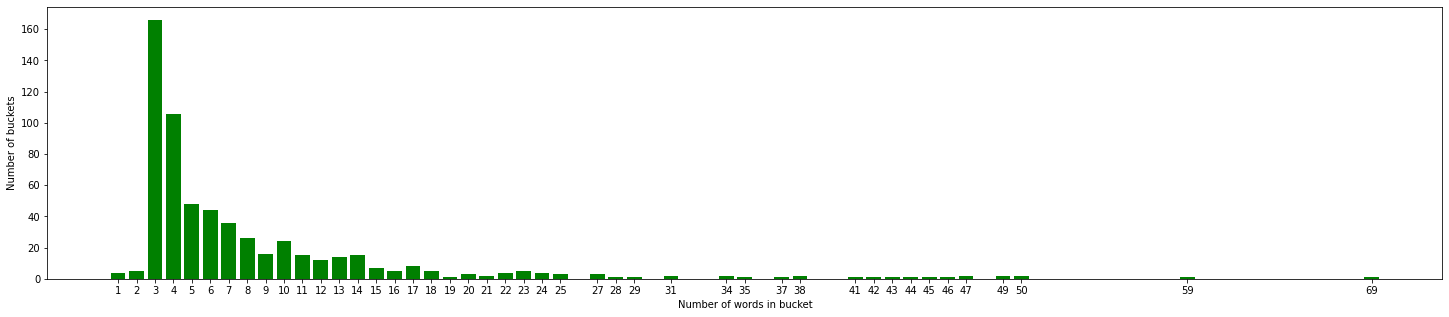

In [5]:
c = Counter(l)
l2 = sorted(c.items(), key=lambda x: x[0])
words, counts = zip(*l2[:-7])

fig, ax = plt.subplots(figsize=(25,5))

ax.bar(x=words, height=counts, color="green")#, width=0.7)
ax.set_xticks(words)
ax.set_ylabel('Number of buckets')
ax.set_xlabel('Number of words in bucket')

plt.savefig("figs/merged_wiktionary_almost_rhyme_and_norsc_buckets.png")

plt.show()

In [25]:
l2[-7:]

[(87, 1), (92, 1), (98, 1), (119, 1), (140, 1), (255, 1), (324, 1)]

In [26]:
ones = [b for b in new_buckets if len(b) == 1]
ones

[['parafin'], ['morn'], ['flystyrt'], ['svært']]

In [27]:
twos = [b for b in new_buckets if len(b) == 2]
twos

[['ekorn', 'jordekorn'],
 ['skotsk', 'spotsk'],
 ['turn', 'nokturn'],
 ['hatsk', 'wattsk'],
 ['tjørn', 'børn']]

In [28]:
threes = [b for b in new_buckets if len(b) == 3]
len(threes)

166

In [56]:
fours = [b for b in new_buckets if len(b) == 4]
len(fours)

106

## Create rhyme pairs

In [30]:
def get_mirrored_dupes(pairs):
    l = list(pairs)
    rem = set()

    for i,(a,b) in enumerate(l):
        if (b,a) in l[i:]:
            rem.add((b, a))
    return rem

In [31]:
import itertools

pairs = set()

for bucket in new_buckets:
    c = list(itertools.combinations(bucket, 2))
    if c:
        rem = get_mirrored_dupes(c)
        c = set(c) - rem
        pairs.update(c)

len(pairs)

155069

In [41]:
df = pd.read_csv("tsvs/good_buckets_pairs.tsv", sep="\t")
df

,word_a,word_b,rhyme
0,lanterner,strandblomststjerner,1
1,trakter,betrakter,1
2,midnattsstund,menneskemunn,1
3,palmesving,engleving,1
4,sjal,gal,1
...,...,...,...
18464,piler,tviler,1
18465,telt,felt,1
18466,smil,strengespill,1
18467,ruter,luter,1


In [44]:
pp = set(zip(df.word_a, df.word_b))
len(pp)

18469

In [46]:
len(pp.intersection(pairs))

8763

In [50]:
pp.update(pairs)
rem = get_mirrored_dupes(pp)
pp -= rem
len(pp), len(pairs), len(pp)-len(pairs)

(155838, 155069, 769)

In [54]:
import pandas as pd

words_a, words_b = zip(*pp)
pair_df = pd.DataFrame({"word_a" : words_a, "word_b": words_b, "rhyme": [1]*len(pp)})
pair_df.to_csv("tsvs/merged_buckets_pairs.tsv", sep="\t", index=False)
pair_df

,word_a,word_b,rhyme
0,Å,vrå,1
1,glatt,blomsterskatt,1
2,forfulgt,skjult,1
3,urfugl,neslesommerfugl,1
4,lampeskinn,skinn,1
...,...,...,...
155833,fremmedland,Cannes,1
155834,luksusbil,utskill,1
155835,fin,derinn,1
155836,bobil,sagastil,1


In [55]:
v = set(list(pair_df.word_a) + list(pair_df.word_b))
len(v)

7541